# Model Optimization

In [1]:
using NbodyGradient, Plots, Optim, DistributionsAD, Distributions, LinearAlgebra, BenchmarkTools
include("likelihood.jl")

logP (generic function with 2 methods)

In [2]:
BJD = 2454950.0 #
ets = 3e-6 # Earth to solar masses

a = Elements(m = 1.03)
b = Elements(
    m = 3.9 * ets,
    P = 13.9,
    t0 = 2454960.9753 - BJD,
    ecosϖ = 0.05,
    esinϖ = -0.026,
    I = π/2,
)
c = Elements(
    m = 7.5 * ets,
    P = 16.2,
    ecosϖ = 0.053,
    esinϖ = -0.039,
    t0 = 2454955.9132 - BJD,
    I = π/2,
)

t0 = 0.0
H = [3,1,1]
ic = ElementsIC(t0, H, a, b, c)

ElementsIC{Float64}
Orbital Elements: 
3×7 Array{Float64,2}:
 1.03      0.0   0.0     0.0     0.0    0.0     0.0
 1.17e-5  13.9  10.9753  0.05   -0.026  1.5708  0.0
 2.25e-5  16.2   5.9132  0.053  -0.039  1.5708  0.0

In [3]:
t0 = 0.0
tmax = b.P * 100
h = b.P / 40.0
intr = Integrator(h, t0, tmax)

Integrator{Float64}(NbodyGradient.ah18!, 0.34750000000000003, 0.0, 1390.0)

In [4]:
s = State(ic)
tt = TransitTiming(intr.tmax, ic)
intr(s,tt)

In [30]:
error = 3 / 1440.0
dist = Normal(0.0, error)
times = tt.tt[2,1:end-3] #.+ rand(dist, length(tt.tt[2,1:end-3]))

data = TimingData([tt.count[2]],[collect(1:length(times))],[times],[error .* ones(length(times))], 0.0);

In [31]:
data.tt

1-element Array{Array{Float64,1},1}:
 [10.974791611139658, 24.87093658423837, 38.76820761952924, 52.715621176673736, 66.62862059174515, 80.54428556609832, 94.4624689936997, 108.37997726003593, 122.29419068784323, 136.20793083105312  …  1261.7908610297084, 1275.7059629003388, 1289.6182721177852, 1303.528202239146, 1317.4906157658013, 1331.3778289908116, 1345.265395338255, 1359.1561165243425, 1373.0474672463404, 1386.9361814147048]

In [32]:
logP(chi_squared, ∇chi_squared, Matrix(ic.elements), H, data, 0.0, intr)

(0.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [33]:
function optimize_times(elements0, data, intr, H)
    # Optimize transit timing model...
    
    θ_init = elements0[2:end,:][:]
    
    function loglike!(F, G, θ)
        elements = zeros(3,7)
        elements[1,1] = 1.03
        elements[2:end,:] .= reshape(θ, 2, 7)
        
        nll, dnll = logP(chi_squared, ∇chi_squared, elements, H, data, 0.0, intr)
        if G != nothing
            G .= dnll
        end
        if F != nothing
            return nll
        end
    end
    
    opt = GradientDescent() # LBFGS()
    
    # Bounds
    lower = get_lower_open(elements0[2:end,:])
    upper = get_upper_open(elements0[2:end,:])
    
    res = Optim.optimize(Optim.only_fg!(loglike!), lower, upper, θ_init, Fminbox(opt),
    Optim.Options(show_trace=true))
    return res
end

optimize_times (generic function with 1 method)

In [34]:
results = optimize_times(Matrix(ic.elements), data, intr, H)

Fminbox
-------
Initial mu = 0.0

Fminbox iteration 1
-------------------
Calling inner optimizer with mu = 0.0

(numbers below include barrier contribution)
Iter     Function value   Gradient norm 
     0     0.000000e+00     0.000000e+00
 * time: 0.0005559921264648438

Exiting inner optimizer with x = [1.17e-5, 2.25e-5, 13.9, 16.2, 10.975300000049174, 5.913199999835342, 0.05, 0.053, -0.026, -0.039, 1.5707963267948966, 1.5707963267948966, 0.0, 0.0]
Current distance to box: 1.16999e-5
Decreasing barrier term μ.



 * Status: success

 * Candidate solution
    Final objective value:     0.000000e+00

 * Found with
    Algorithm:     Fminbox with Gradient Descent

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = 0.00e+00 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    1
    f(x) calls:    2
    ∇f(x) calls:   2


In [35]:
# Compare optimized elements to initial elements
elements_fit = zeros(3,7)
elements_fit[1,1] = 1.03
elements_fit[2:end,:] .= reshape(results.minimizer, 2, 7)
elements_fit .- ic.elements

3×7 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

## Misc.

In [16]:
function chi2(θ::Vector{T}, data::Vector{T}, error::Vector{T}) where T <: Real
    # Make the model here...
    
    # Convert parameter vector into elements array
    elements = zeros(3,7)
    elements[1,1] = 1.03
    elements[2:end,:] .= reshape(θ, 2, 7)
    
    t0 = 0.0
    H = 3
    ic = ElementsIC(t0, H, elements)
    h = ic.elements[2,2] / 40
    tmax = ic.elements[2,2] * 101
    intr = Integrator(h, t0, tmax)
    s = State(ic)
    tt = TransitTiming(intr.tmax, ic)
    intr(s,tt)
    ## ##
    
    N = length(data)
    model = tt.tt[2,1:N] # Make them the same size
    
    chisq = 0.0
    for i in 1:N
        chisq += ((data[i] - model[i]) / error[i])^2
    end
    return chisq
end

chi2 (generic function with 1 method)

In [18]:
σ = 5 / 1440.0 # 3 minutes, in days
dist = Normal(0.0, σ)
data = tt.tt[2,1:end-4] #.+ rand(dist, length(tt.tt[2,1:end-4]))
error = ones(length(data)) .* σ
p0 = ic.elements[2:end, :][:]
chi2(p0, data, error) / (length(data) - 7*2 - 1)

0.0

In [8]:
function optimize_times(p0, data, error)
    # Optimize transit timing model...
    opt = NelderMead()
    res = Optim.optimize(θ->chi2(θ, data, error), p0, opt)
    return res
end

optimize_times (generic function with 1 method)

In [36]:
optimize_times(p0, data, error)

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     9.997829e+01

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   1281  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    2367


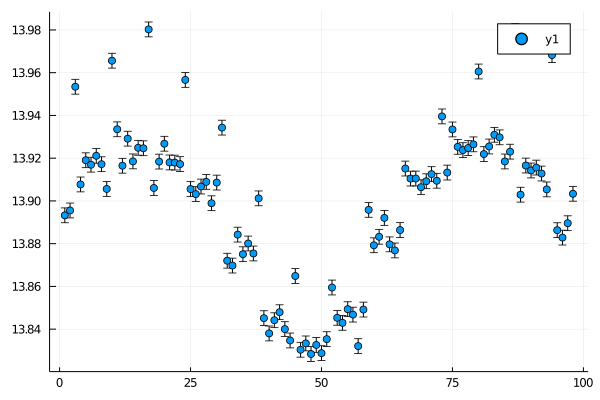

In [23]:
scatter(diff(data), yerr=error)